In [25]:
import torch
import torchvision.transforms.functional as tv
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import pickle
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
RANDOM_STATE = 42

In [3]:
def create_data():
    images = []
    final = []
    label = []
    name = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
    for dis in name:
        folder_path = 'Corn Images/' + dis
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            images.append(img)
            label.append(dis)
    final.append(images)
    final.append(label)
    return final

In [4]:
result = create_data()
dataset = pd.DataFrame({'Images': result[0], 'Label': result[1]})

In [5]:
print(dataset[dataset['Label'] == 'Blight'].count())
print(dataset[dataset['Label'] == 'Common_Rust'].count())
print(dataset[dataset['Label'] == 'Gray_Leaf_Spot'].count())
print(dataset[dataset['Label'] == 'Healthy'].count())

Images    1146
Label     1146
dtype: int64
Images    1306
Label     1306
dtype: int64
Images    574
Label     574
dtype: int64
Images    1162
Label     1162
dtype: int64


In [6]:
dataset[:100]

,Images,Label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
...,...,...
95,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
96,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
97,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight
98,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Blight


In [7]:
def show_image(image):
    image = image.copy()
    plt.imshow(image, aspect='equal')

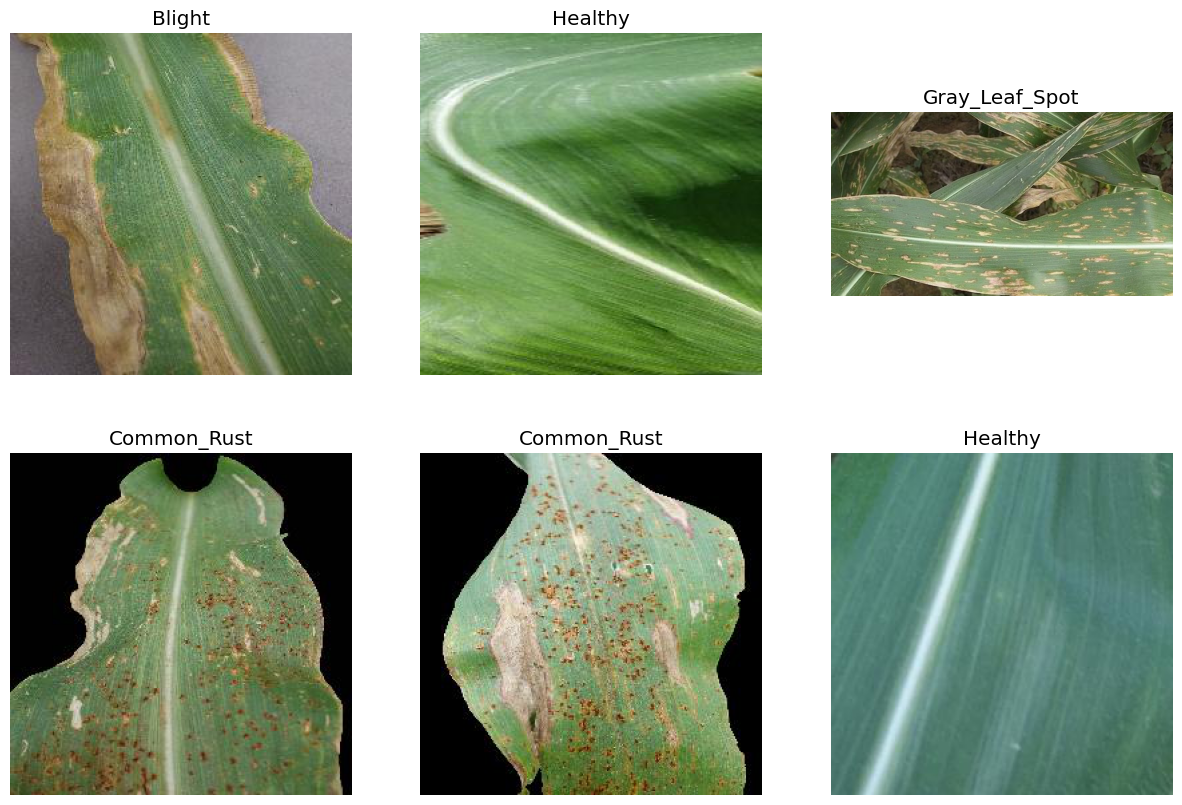

In [8]:
rng = np.random.default_rng(RANDOM_STATE)
n_cols = 3
n_rows = 2
indexes = rng.choice(len(dataset), n_cols * n_rows)

plt.figure(figsize=(15, 10))

for ii, id in enumerate(indexes, 1):
    plt.subplot(n_rows, n_cols, ii)
    image = dataset['Images'][int(id)]
    show_image(image)
    plt.title(dataset['Label'][int(id)])
    plt.axis('off')

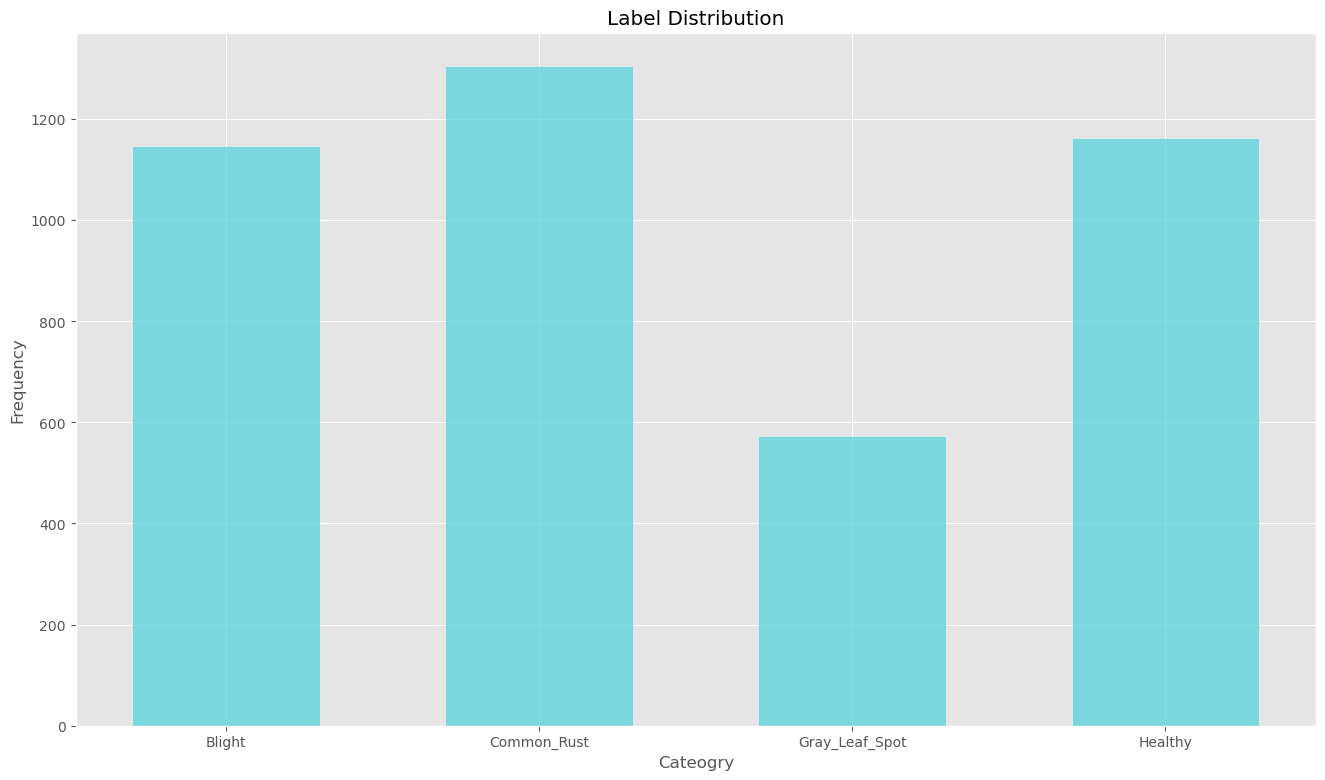

In [9]:
palette = sns.color_palette('hls', 4)

plt.figure(figsize=(16, 9))
sns.histplot(dataset['Label'], bins=4, shrink=0.6, kde=False, color=palette[2])

plt.xlabel('Cateogry')
plt.ylabel('Frequency')
plt.title('Label Distribution')

# Show the plot
plt.show()

In [10]:
x = dataset[['Images', 'Label']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x['Images'], x['Label'], test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=x['Label'])

In [12]:
class Resize:
    def __init__(self, new_size=(224, 224)):
        self.new_width = new_size[0]
        self.new_height = new_size[1]

    def __call__(self, data):
        image = data
        image = tv.resize(image, (self.new_width, self.new_height))
        return image

In [13]:
class ImageAdjustment: # Adjust brightness, contrast and gamma filter
    def __init__(self, p=0.3, brightness=0.8, contrast=0.8, gamma=0.4):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
        self.brightness = brightness
        self.contrast = contrast
        self.gamma = gamma
    
    def __call__(self, data):
        image = data
        
        if np.random.random() < self.p:
            brightness = 1 + np.random.uniform(-self.brightness, self.brightness)
            image = tv.adjust_brightness(image, brightness)
        
        if np.random.random() < self.p:
            contrast = 1 + np.random.uniform(-self.contrast, self.contrast)
            image = tv.adjust_contrast(image, contrast)
            
        if np.random.random() < self.p:
            gamma = 1 + np.random.uniform(-self.gamma, self.gamma)
            image = tv.adjust_gamma(image, gamma)
        
        return image

In [14]:
class RandomRotation:
    def __init__(self, p=0.3, degrees=30):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
        self.degrees = degrees
    
    def __call__(self, data):
        image = data
        
        if np.random.random() < self.p:
            angle = np.random.uniform(-self.degrees, self.degrees)
            image = tv.rotate(image, angle)
        
        return image

In [15]:
class RandomHorizontalFlip:
    def __init__(self, p=0.3):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
    
    def __call__(self, data):
        image = data
        
        if np.random.random() < self.p:
            image = tv.hflip(image)
        
        return image

In [16]:
class RandomVerticalFlip:
    def __init__(self, p=0.3):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
    
    def __call__(self, data):
        image = data
        
        if np.random.random() < self.p:
            image = tv.vflip(image)
        
        return image

In [17]:
class RandomZoom:
    def __init__(self, p=0.3, zoom=0.2):
        if not 0 <= p <= 1:
            raise ValueError(f'p must be in [0, 1], got {p}.')
        self.p = p
        self.zoom = zoom
    
    def __call__(self, data):
        image = data
        
        if np.random.random() < self.p:
            zoom_factor = 1 + np.random.uniform(-self.zoom, self.zoom)
            image = tv.resize(image, (int(image.size[1] * zoom_factor), int(image.size[0] * zoom_factor)))
        
        return image

In [18]:
class ToTensor:
    def __init__(self):
        pass
    
    def __call__(self, data):
        image = data
        
        image = tv.to_tensor(image)
        
        return image

In [19]:
class ToPIL:
    def __init__(self):
        pass
    
    def __call__(self, data):
        image = data
        
        image = tv.to_pil_image(image)
        
        return image

In [20]:
img = X_train[42]
transformation = Compose([Resize(), ImageAdjustment(), ToTensor()])
new_image = transformation((img))
print(f'new image type {new_image.dtype}, shape = {new_image.shape}')

new image type torch.float32, shape = torch.Size([3, 224, 224])


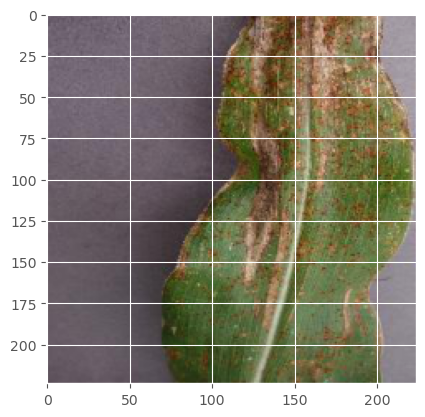

In [21]:
new_image = ToPIL()((new_image))
show_image(new_image)

In [33]:
class CornDataset(Dataset):
    def __init__(self, dataset, transformation):
        self.dataset = dataset.reset_index(drop=True)
        self.transformation = transformation
    
    def __getitem__(self, index):
        image = self.dataset[index]
        image = self.transformation((image))
        return image.to(device)

    def __len__(self):
        return len(self.dataset)

In [34]:
train_transformation = Compose([Resize(), RandomRotation(), RandomHorizontalFlip(), RandomVerticalFlip(), RandomZoom(), ToTensor()])
test_transformation = Compose([Resize(), ToTensor()])

train_dataset = CornDataset(X_train, train_transformation)
test_dataset = CornDataset(X_test, test_transformation)

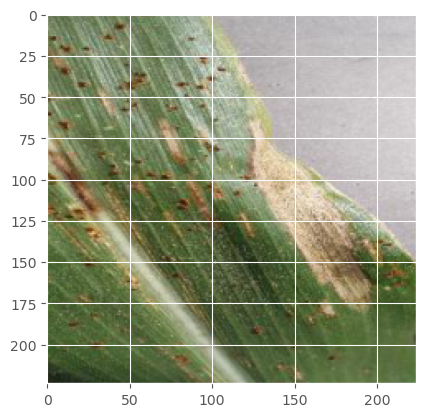

In [37]:
image = train_dataset[34]
show_image(ToPIL()(image))

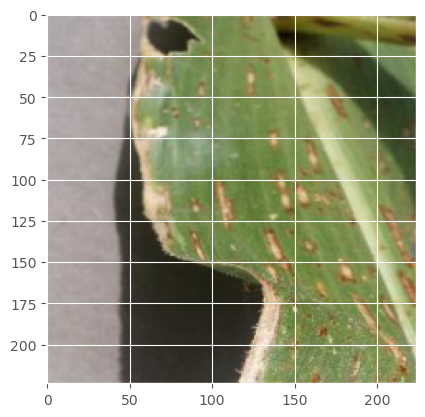

In [38]:
image = test_dataset[34]
show_image(ToPIL()(image))